# Evaluation on DIV2K validation set  (Model using MSE as loss funtion)

Evaluate two metrics PSNR and SSIM of trained models on 100 validation images of bicubic and unknown degradations at scale of 2 and 4.


In [1]:
from tensorflow import config

gpu_devices = config.experimental.list_physical_devices('GPU')

for device in gpu_devices: config.experimental.set_memory_growth(device, True)

## Load testing images from directory

In [3]:
# load testing images from directory

import os
import numpy as np
from PIL import Image

# LR_valid_path = './datasets/DIV2K_valid_LR_unknown/X2/'
# LR_valid_path = './datasets/DIV2K_valid_LR_unknown/X4/'
# LR_valid_path = './datasets/DIV2K_valid_LR_bicubic/X4/'

LR_valid_path = './datasets/DIV2K_valid_LR_bicubic/X2/'
HR_valid_path = './datasets/DIV2K_valid_HR//'

LR_train_imgs = []
HR_train_imgs = []

for path, subpath, files in os.walk(LR_train_path):
    files.sort()
    for i in files:
        if i == '.DS_Store':
            continue
        img = Image.open(LR_train_path + i)
        LR_train_imgs.append(np.asarray(img))

for path, subpath, files in os.walk(HR_train_path):
    files.sort()
    for i in files:
        if i == '.DS_Store':
            continue
        img = Image.open(HR_train_path + i)
        HR_train_imgs.append(np.asarray(img)) 

print(len(LR_train_imgs))
print(len(HR_train_imgs))

100
100


## Load trained model for evaluation

In [5]:
import tensorflow as tf
from keras.models import load_model

model = load_model('./model_and_history/final_mse_unknown_4848_12000_subpixel_X2.h5', custom_objects={'tf': tf})
#final_mse_unknown_4848_12000_subpixel_X2

#model.summary()

Using TensorFlow backend.


In [6]:
# normaliza imgs from 0~255 to 0~1

def normalize(imgs):
    return imgs / 255

def denormalize(imgs):
    imgs = imgs * 255
    return imgs.astype(np.uint8)

for i in range(len(LR_valid_imgs)):
    LR_valid_imgs[i] = normalize(LR_valid_imgs[i])

## Use trained model to predict test images
Smaller stride can result in better performance but cost more time to recover as more patches are involved. Time needed to predict 100 validation images are recorded with corresponding stride.

In [7]:
# predict and reconstruct test images
# stride should be smaller than patch size to cover all the pixels

from extract_patches import *

test_num = 100
patch_height = 48
patch_width = 48
stride = 40
up_scale = 2

import time

time_start=time.time()

predicted_HR_list = test_patch(LR_valid_imgs, test_num, patch_height, patch_width, stride, model, up_scale)

time_end=time.time()
print('Time cost to predict: ', time_end-time_start, 's')

for i in range(len(predicted_HR_list)):
    predicted_HR_list[i] = denormalize(predicted_HR_list[i])

    
# Bi_mse_X2
# stride=48, test_num=100, Time cost to predict:  233.13077068328857 s
# strode=30, test_num=100, Time cost to predict:  506.7143270969391 s
# strode=20, test_num=100, Time cost to predict:  1068.9724361896515 s

# Bi_mse_X4
# stride=40, test_num=100, Time cost to predict:  191.99524521827698 s
# strode=30, test_num=100, Time cost to predict:  272.7221348285675 s
# strode=20, test_num=100, Time cost to predict:  553.5177254676819 s

# unknown_mse_X2
# stride=40, test_num=100, Time cost to predict:  386.90919494628906 s
# strode=30, test_num=100, Time cost to predict:  590.9095602035522 s
# strode=20, test_num=100, Time cost to predict:  1083.2623493671417 s

# unknown_mse_X4
# stride=40, test_num=100, Time cost to predict:  213.57782554626465 s
# strode=30, test_num=100, Time cost to predict:  339.281866312027 s
# strode=20, test_num=100, Time cost to predict:  612.3734095096588 s



Time cost to predict:  37.40575861930847 s


In [8]:
# compare with HR images 
# calculate PSNR(peak_signal_noise_ratio) and SSIM(structural_similarity) metrics

from skimage.metrics import peak_signal_noise_ratio, structural_similarity

PSNR_val = []
SSIM_val = []

for i in range(len(predicted_HR_list)):
    PSNR = peak_signal_noise_ratio(HR_valid_imgs[i], predicted_HR_list[i])
    SSIM = structural_similarity(HR_valid_imgs[i], predicted_HR_list[i], multichannel=True)
    PSNR_val.append(PSNR)
    SSIM_val.append(SSIM)

print('PSNR: ', PSNR_val)
print('SSIM: ', SSIM_val)

PSNR:  [32.50786147965152]
SSIM:  [0.8546183189416631]


In [12]:
# save evaluation results

import pickle

with open('./evaluation/unknown_x4_psnr_stride20.pkl','wb') as f2:
    pickle.dump(PSNR_val, f2)

with open('./evaluation/unknown_x4_ssim_stride20.pkl','wb') as f3:
    pickle.dump(SSIM_val, f3)

## visualize the recovered HR image

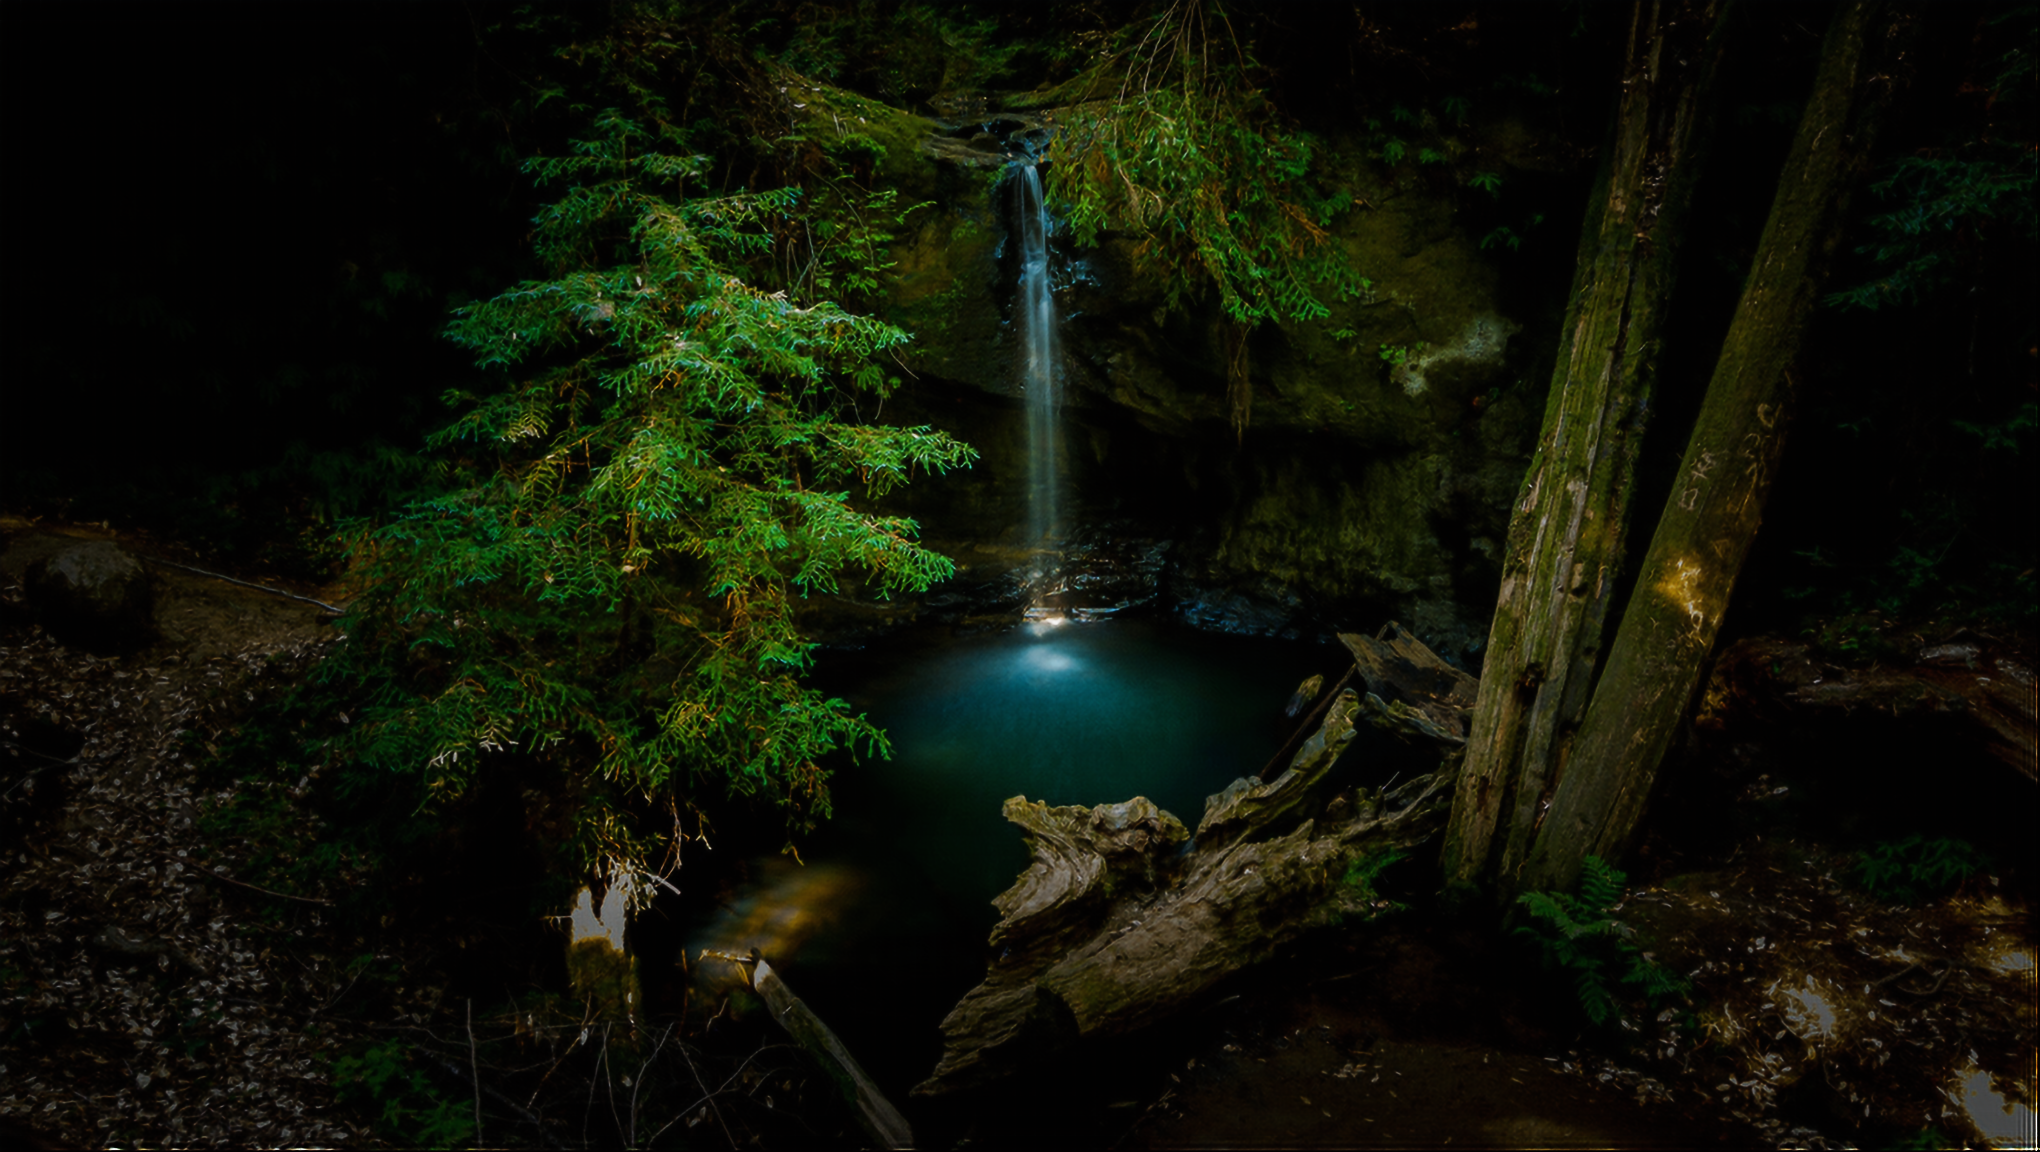

In [9]:
# mse

test_index = 0
Image.fromarray(predicted_HR_list[test_index], 'RGB')

In [10]:
im = Image.fromarray(predicted_HR_list[test_index], 'RGB')
im.save('./pictures/unknown_mse_52.png')

## compare the results

In [1]:
import pickle

with open('./evaluation/bi_x2_psnr_stride20.pkl','rb') as f:
    psnr_res = pickle.load(f)
with open('./evaluation/bi_x2_ssim_stride20.pkl','rb') as f:
    ssim_res = pickle.load(f)

In [2]:
import numpy as np

print('psnr_max:', max(psnr_res), ', and image index is:', psnr_res.index(max(psnr_res)))
print('psnr_min:', min(psnr_res), ', and image index is:', psnr_res.index(min(psnr_res)))
print('psnr_median:', np.median(psnr_res))
print('psnr_mean:', np.mean(psnr_res))

psnr_max: 42.894413116028474 , and image index is: 42
psnr_min: 23.113128667443004 , and image index is: 6
psnr_median: 32.617856096608335
psnr_mean: 32.18825271505139


In [3]:
print('ssim_max:', max(ssim_res), ', and image index is:', ssim_res.index(max(ssim_res)))
print('ssim_min:', min(ssim_res), ', and image index is:', ssim_res.index(min(ssim_res)))
print('ssim_median:', np.median(ssim_res))
print('ssim_mean:', np.mean(ssim_res))

ssim_max: 0.9858030694169356 , and image index is: 42
ssim_min: 0.6825128159621986 , and image index is: 28
ssim_median: 0.9334216176263961
ssim_mean: 0.9204005946175671
